# PandasMonitor🐼🖥️

In [1]:
import pandas as pd
import os

AGGREGATIES = ["13 centrumsteden", "Gemeenten groter dan 50.000 inw.", "Gemeenten kleiner dan 10.000 inw.", "Gemeenten van 10.000 tot 20.000 inw.", 
               "Gemeenten van 20.000 tot 30.000 inw.", "Gemeenten van 30.000 tot 50.000 inw.", "Vlaams Gewest"]
OUDE_GEMEENTEN = ["Hechtel"] #gemeenten die na fusie niet meer zelfstandig bestaan

## tabel van gemeenten opbouwen
- Tussen 2017 en 2020 nog een complexiteit fusies, maar niet tussen 2020 en 2024
- Enkel gemeentefusies op 1 januari 2019 en 1 januari 2025 https://lokaalbestuur.vlaanderen.be/strategische-projecten/fusie-van-gemeenten/fusietrajecten

In [14]:
VLAAMSE_RAND = ["Asse", "Beersel", "Dilbeek", "Grimbergen", "Hoeilaart", "Machelen", "Meise", "Merchtem", "Overijse", "Sint-Pieters-Leeuw", "Tervuren", "Vilvoorde", "Zaventem"]
CENTRUMSTEDEN = ["Aalst", "Antwerpen", "Brugge", "Genk", "Gent", "Hasselt", "Kortrijk", "Leuven", "Mechelen", "Oostende", "Roeselare", "Sint-Niklaas", "Turnhout"]
df_gem = pd.read_excel("gemeenten/benchmarks_belfiusclusters.xlsx", 0)
df_gem = df_gem.rename(columns={"Cluster": "Cluster ID", "Cluster (benaming)": "Cluster"})
df_gem['Vlaamse Rand'] = df_gem['Gemeente'].isin(VLAAMSE_RAND)
df_gem['Centrumstad'] = df_gem['Gemeente'].isin(CENTRUMSTEDEN)
df_gem_inw = pd.read_excel("gemeenten/inwoneraantal.xlsx", 0, usecols=["Gemeente", "Jaar", "Aantal inwoners"])
df_gem_inw = df_gem_inw[df_gem_inw['Jaar'] == 2022]
df_gem_inw = df_gem_inw.drop(columns=['Jaar'])
def inwonerscategorie(row):
    if row['Aantal inwoners'] < 10000:
        return "kleiner dan 10.000 inwoners"
    if row['Aantal inwoners'] <= 20000:
        return "van 10.000 tot 20.000 inwoners"
    if row['Aantal inwoners'] <= 30000:
        return "van 20.000 tot 30.000 inwoners"
    if row['Aantal inwoners'] <= 50000:
        return "van 30.000 tot 50.000 inwoners"
    else:
        return "groter dan 50.000 inwoners"
df_gem_inw['Aantal inwoners (categorie)'] = df_gem_inw.apply(inwonerscategorie, axis=1)
df_gem = df_gem.join(df_gem_inw.set_index('Gemeente'), on='Gemeente')
df_gem.to_excel("output/gemeenten_dim.xlsx", index=False)
df_gem.info()
df_gem.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   NIS                          300 non-null    int64 
 1   Gemeente                     300 non-null    object
 2   Provincie                    300 non-null    object
 3   Cluster ID                   300 non-null    object
 4   Cluster                      300 non-null    object
 5   Clustergroep                 300 non-null    object
 6   Vlaamse Rand                 300 non-null    bool  
 7   Centrumstad                  300 non-null    bool  
 8   Aantal inwoners              300 non-null    int64 
 9   Aantal inwoners (categorie)  300 non-null    object
dtypes: bool(2), int64(2), object(6)
memory usage: 19.5+ KB


,NIS,Gemeente,Provincie,Cluster ID,Cluster,Clustergroep,Vlaamse Rand,Centrumstad,Aantal inwoners,Aantal inwoners (categorie)
0,11001,Aartselaar,Antwerpen,V10,Gemeenten met economische aantrekking en vergrijzende bevolking,Gemeenten met economische aantrekking,False,False,14610,van 10.000 tot 20.000 inwoners
1,11002,Antwerpen,Antwerpen,V15,Grote en regionale steden,Grote en regionale steden,False,True,530630,groter dan 50.000 inwoners
2,11004,Boechout,Antwerpen,V3,Woongemeenten met hogere inkomens,Woongemeenten,False,False,13733,van 10.000 tot 20.000 inwoners
3,11005,Boom,Antwerpen,V14,Goeduitgeruste gemeenten en kleine steden met toenemend aantal jongeren,Verstedelijkte gemeenten,False,False,18832,van 10.000 tot 20.000 inwoners
4,11007,Borsbeek,Antwerpen,V14,Goeduitgeruste gemeenten en kleine steden met toenemend aantal jongeren,Verstedelijkte gemeenten,False,False,11226,van 10.000 tot 20.000 inwoners


## dimensietabel met alle indicatoren opbouwen

In het overzicht van alle indicatoren met hun documentatie [GemeenteStadsmonitor_indicatoren.xlsx](https://gemeente-stadsmonitor.vlaanderen.be/indicatoren) ontbreekt helaas een unieke key die overal elders gebruikt wordt om de indicator te identificeren.

### overzichtstabel indicatoren zonder indicator IDs inladen

In [16]:
DTYPES = {
    'Thema': 'category', 
    'Type': 'category',
}
df_ind = pd.read_excel("GemeenteStadsmonitor_indicatoren.xlsx", 0, dtype=DTYPES)
df_ind.info()
df_ind.columns = df_ind.columns.str.strip() #'Naam indicator ' contains a trailing space😑
df_ind['naam'] = df_ind['Naam indicator'].str.strip().str.replace(" ", "_").str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Thema                 418 non-null    category
 1   Type                  418 non-null    category
 2   Naam indicator        418 non-null    object  
 3   Definitie             418 non-null    object  
 4   Eenheid               418 non-null    object  
 5   Ratio                 410 non-null    object  
 6   Teller                418 non-null    object  
 7   Noemer                409 non-null    object  
 8   Vraagstelling survey  140 non-null    object  
 9   Bron                  418 non-null    object  
dtypes: category(2), object(8)
memory usage: 27.2+ KB


### indicator IDs toevoegen voor surveyindicatoren

In [17]:
df_surveyind = pd.read_excel("GSM_surveyresultaten_Alle_indicatoren.xlsx", 0, dtype={'Thema': 'category'}, nrows=140) #nrows omdat er nog rommel onder de tabel zit
df_surveyind.info()
df_surveyind.columns = df_surveyind.columns.str.strip()
df_surveyind['naam'] = df_surveyind['Naam indicator'].str.strip().str.replace(" ", "_").str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Thema            140 non-null    category
 1   ID               140 non-null    object  
 2   Naam indicator   140 non-null    object  
dtypes: category(1), object(2)
memory usage: 2.5+ KB


In [18]:
df_surveyind = df_ind.merge(df_surveyind[['naam', 'ID']], left_on='naam', right_on='naam', how='inner')
df_surveyind.info() #slechts 139 waarden voor 'Vraagstelling survey', ontbreekt bij WE_S_01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Thema                 140 non-null    category
 1   Type                  140 non-null    category
 2   Naam indicator        140 non-null    object  
 3   Definitie             140 non-null    object  
 4   Eenheid               140 non-null    object  
 5   Ratio                 140 non-null    object  
 6   Teller                140 non-null    object  
 7   Noemer                140 non-null    object  
 8   Vraagstelling survey  139 non-null    object  
 9   Bron                  140 non-null    object  
 10  naam                  140 non-null    object  
 11  ID                    140 non-null    object  
dtypes: category(2), object(10)
memory usage: 12.4+ KB


### indicator IDs toevoegen voor registerindicatoren

In [19]:
df_regind = pd.DataFrame(columns=["Thema", 'ID', 'Naam indicator']) 
for f in os.scandir("registerindicatoren"):
    if not f.is_file():
        continue
    df_tmp = pd.read_excel(f.path, 0, dtype={'Thema': 'category'})
    df_tmp.columns = df_tmp.columns.str.strip() #'Naam indicator ' contains a trailing space😑
    df_tmp = df_tmp.dropna() #rommel onder de tabel
    df_regind = pd.concat([df_regind, df_tmp])
df_regind.info()
df_regind['naam'] = df_regind['Naam indicator'].str.strip().str.replace(" ", "_").str.lower()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 0 to 18
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Thema           0 non-null      object
 1   ID              282 non-null    object
 2   Naam indicator  282 non-null    object
dtypes: object(3)
memory usage: 8.8+ KB


In [20]:
df_regind = df_ind.merge(df_regind[['naam', 'ID']], left_on='naam', right_on='naam', how='inner')
df_regind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 0 to 274
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Thema                 275 non-null    category
 1   Type                  275 non-null    category
 2   Naam indicator        275 non-null    object  
 3   Definitie             275 non-null    object  
 4   Eenheid               275 non-null    object  
 5   Ratio                 267 non-null    object  
 6   Teller                275 non-null    object  
 7   Noemer                266 non-null    object  
 8   Vraagstelling survey  0 non-null      object  
 9   Bron                  275 non-null    object  
 10  naam                  275 non-null    object  
 11  ID                    275 non-null    object  
dtypes: category(2), object(10)
memory usage: 24.3+ KB


### combineer registerindicatoren en surveyindicatoren tot een nieuwe tabel met alle indicatoren mét ID

In [21]:
df_ind = pd.concat([df_surveyind, df_regind])
df_ind = df_ind.drop_duplicates() #Zitten enkele dubbels in thema Integratie
df_ind.to_excel("output/indicatoren_dim.xlsx", index=False)
df_ind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 0 to 274
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Thema                 413 non-null    category
 1   Type                  413 non-null    category
 2   Naam indicator        413 non-null    object  
 3   Definitie             413 non-null    object  
 4   Eenheid               413 non-null    object  
 5   Ratio                 405 non-null    object  
 6   Teller                413 non-null    object  
 7   Noemer                404 non-null    object  
 8   Vraagstelling survey  139 non-null    object  
 9   Bron                  413 non-null    object  
 10  naam                  413 non-null    object  
 11  ID                    413 non-null    object  
dtypes: category(2), object(10)
memory usage: 36.4+ KB


## feitentabellen bouwen
- De verschillende sheets met metingen hebben vaak een verschillend aantal kolommen en kunnen zo niet samengevoegd worden; unpivot nodig
- Sommige kolommen zijn repetitief of niet nuttig voor verdere analyse: vb. de noemer van een ratio (per aantal inwoners of per aantal gezinnen)
- We willen alvast berekeningen toevoegen (vb. NPS-score)
- We willen voorkeursmeetcategorieën aanduiden voor verdere analyse: vb. %Ja voor een indicator waar we zowel %Ja als %Nee hebben. 
- Dit zou ook met PowerBI transformaties kunnen, maar pandas gaat sneller, is eenvoudiger (voor mij), en levert excelbestanden op die nadien kunnen dienen voor andere gebruikers.

### feitentabel surveyresultaten bouwen
In het oorspronkelijk bestand GSM_surveyresultaten_Alle_indicatoren zitten verwante indicatoren samen in één sheet. Vb. MO_S_01_1, MO_S_01_2, MO_S_01_3 samen in sheet MO_S_01. Ik heb manueel manueel een bestand gecreërd waar met apart sheets voor verwante indicatoren: *GSM_surveyresultaten_Alle_indicatoren_consistent_sheetnames.xlsx*
Stappen:
- modeldataframe creëren.
- sheets overlopen behalve de eerste (is overzichtssheet) en inlezen
- leading & trailing spaties wissen uit kolomnamen
- leading & trailing spaties wissen uit kolom [Gemeente]
- kolommen [NIS-code] en [Censtrumstad] of [Centrumstad?] laten vallen. [NIS-code] niet uniek, wegens "/" waarden voor "Vlaams Gewest", "Gemeenten met meer dan 50K inw" etc., dus geen natural key, geen plaats in fact table.
- kolom [Indicator ID] toevoegen op basis van sheetname
- kolom [Indicator] (=naam indicator) zou ik kunnen laten vallen, omdat die kan afgeleid worden van [Indicator ID], maar maakt het bestand minder leesbaar en fouten in de data minder detecteerbaar
- kolom [Item] toevoegen als ze nog niet bestaat, voor uniformiteit
- kolom [NPS (%)] toevoegen indien van toepassing
- antwoordcategorieën unpivoten in kolom [Categorie] en [Waarde]
- rijen met [Waarde]=='nvt' droppen
- kolom [Eerste antwoordcategorie] (True/False) toevoegen. Nadien eenvoudig om te filteren (o.m. in PowerBI) als je per indicator slechts één waarde wilt tonen. Zie https://pandas.pydata.org/docs/user_guide/categorical.html voor  concept categorical data in statistiek, en hoe de volgorde gedefinieerd wordt.
    - dat is standaard de eerste categorie-kolom, of de NPS als die berekend is
    - deze standaard aanpak werkt bijna altijd. indien niet, gewenste categorie-kolom op eerste plaats zetten tijdens manuele data cleaning, ipv. indicatorspecifieke code te schrijven. vb. hieronder ga ik kolom "Auto (%)" voorop zetten.
    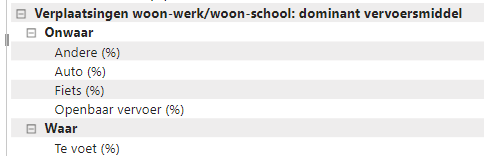
- sheets achter mekaar plakken en wegschrijven naar een nieuw excelbestand in de map survey_facts.xlsx

In [2]:
%%time
DTYPES = {'Jaar': 'int', 'Waarde': 'float', 'Eerste categorie': 'bool'}
#category dtype gaat verloren bij concat https://stackoverflow.com/questions/45639350/retaining-categorical-dtype-upon-dataframe-concatenation
CATEGORICALS = {'Indicator ID': 'category', 'Indicator': 'category', 'Gemeente': 'category', 'Item': 'category', 'Categorie': 'category'} 

collation = []

with pd.ExcelFile("GSM_surveyresultaten_Alle_indicatoren_consistent_sheetnames.xlsx") as xlsx:
    for sheet_name in xlsx.sheet_names[1:]: #skip first sheet (=overview)
        df_tmp = pd.read_excel(xlsx, sheet_name)
        df_tmp.columns = df_tmp.columns.str.strip() #strip leading & trailing whitespace from column names
        #Gemeentenamen beginnen met een spatie bij de surveyindicatoren, en ergens staat Puurs-Sint-Amands met extra spaties gespeld als 'Puurs - Sint-Amands'
        #Kan niet zomaar alle spaties wissen, want dan zijn aggregaties als "Vlaams Gewest" en gemeenten "De Haan" ook de klos.
        df_tmp['Gemeente'] = df_tmp['Gemeente'].str.strip() 
        df_tmp['Gemeente'] = df_tmp['Gemeente'].replace({'Puurs - Sint-Amands': 'Puurs-Sint-Amands'})  
        #schrap meetwaarden voor gemeenten die niet meer bestaan
        df_tmp = df_tmp[~df_tmp['Gemeente'].isin(OUDE_GEMEENTEN)] 
        #NIS-code droppen
        df_tmp = df_tmp.drop(columns=['NIS-code'])
        #Kolom centrumstad niet relevant voor ons. 
        if 'Centrumstad' in df_tmp:
            df_tmp = df_tmp.drop(columns=['Centrumstad'])
        if 'Centrumstad?' in df_tmp:
            df_tmp = df_tmp.drop(columns=['Centrumstad?'])
        #voorkeursmeetcategorie standaard vaststellen op eerste categorie
        index_of_first_category_column = df_tmp.columns.get_loc("Jaar")+1
        first_category = df_tmp.columns[index_of_first_category_column]
        #Indicator key toevoegen  
        df_tmp['Indicator ID'] = sheet_name 
        #Voeg een lege Item-kolom toe als er nog geen bestaat, voor de uniformiteit
        if 'Item' not in df_tmp:
            df_tmp['Item'] = None
        #Bereken NPS-scores:
        NPS = 'NPS (%)'
        if 'Neutraal (%)' in df_tmp:
            if ('Oneens (%)' in df_tmp) and ('Eens (%)' in df_tmp):
                df_tmp[NPS] = df_tmp['Eens (%)'] - df_tmp['Oneens (%)']
                first_category = NPS
            if ('Ontevreden (%)' in df_tmp) and ('Tevreden (%)' in df_tmp):
                df_tmp[NPS] = df_tmp['Tevreden (%)'] - df_tmp['Ontevreden (%)']
                first_category = NPS
            if ('Weinig (%)' in df_tmp) and ('Veel (%)' in df_tmp):
                df_tmp[NPS] = df_tmp['Veel (%)'] - df_tmp['Weinig (%)']
                first_category = NPS         
        #unpivot
        df_tmp = df_tmp.melt(id_vars=['Indicator ID', 'Indicator', 'Gemeente', 'Item', 'Jaar'], var_name="Categorie", value_name="Waarde")
        #string 'nvt' geeft problemen bij conversie kolom naar getal in Power BI:
        df_tmp = df_tmp[df_tmp['Waarde'] != 'nvt'] #filter out all rows with waarde = 'nvt'; alternatief: df_tmp['Waarde'] = df_tmp['Waarde'].replace('nvt',None)
        df_tmp['Eerste categorie'] = (df_tmp['Categorie'] == first_category)
        df_tmp = df_tmp.astype(DTYPES)
        collation.append(df_tmp)

df_surveyfacts = pd.concat(collation)
df_surveyfacts.info()
df_surveyfacts = df_surveyfacts.astype(CATEGORICALS) #eerder heeft geen zin, dtype category gaat steeds verloren bij concat, zie https://stackoverflow.com/questions/45639350/retaining-categorical-dtype-upon-dataframe-concatenation
df_surveyfacts.info()

df_surveyfacts.to_excel('output/survey_facts.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364346 entries, 0 to 1447
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Indicator ID      364346 non-null  object 
 1   Indicator         364346 non-null  object 
 2   Gemeente          364346 non-null  object 
 3   Item              224061 non-null  object 
 4   Jaar              364346 non-null  int32  
 5   Categorie         364346 non-null  object 
 6   Waarde            364346 non-null  float64
 7   Eerste categorie  364346 non-null  bool   
dtypes: bool(1), float64(1), int32(1), object(5)
memory usage: 21.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364346 entries, 0 to 1447
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Indicator ID      364346 non-null  category
 1   Indicator         364346 non-null  category
 2   Gemeente          364346 non-nu

### feitentabellen registerdata bouwen
De tabellen met registerdata zijn nog inconsistenter dan de surveydata. 
Manueel door alle sheets gegaan
- om fouten recht te zetten (vb. verkeerde benamingen van kolommen)
- itemkolommen (vb. [Herkomst]) te hernoemen naar [Item] voor de consistentie
- en passant overbodige kolommen te schrappen (NIS-code, centrumstad, noemer in berekeningen)
- sommige sheets te schrappen wegens te complex/gedetailleerd.
- integratie: zeer gedetailleerd; is er geen handvol maatstaven om de integratie te meten?
- lokaal bestuur: optelling van verschillende besturen maken (Gemeente en OCMW, AGB)
- onderwijs: zeer gedetailleerd, heel veel dubbelop
- soms onvermijdelijk om eigen pivot table te maken (vb. MO07, alle types ongevallen van alle types actieve weggebruikers samentellen)
- zou ook moeten bij schoolse vertraging lager onderwijs
- mag hier niet filteren op 2017 / 2020: data zijn vaak niet recent beschikbaar (vb. maar tot 2019 of 2018)
- regelmatig een item uitfilteren om enkel het interessantste over te houden (vb. WO01, aantal gebouwen/woongelegenheden, enkel woongelegenheden overhouden)
    - vb. WO02: *Aantal gebouwen opgericht na 1981*, Aantal gebouwen opgericht van 1900 tot 1918, Aantal gebouwen opgericht van 1919 tot 1945, Aantal gebouwen opgericht van 1946 tot 1961, Aantal gebouwen opgericht van 1962 tot 1970, Aantal gebouwen opgericht van 1971 tot 1981, *Aantal gebouwen opgericht voor 1900*

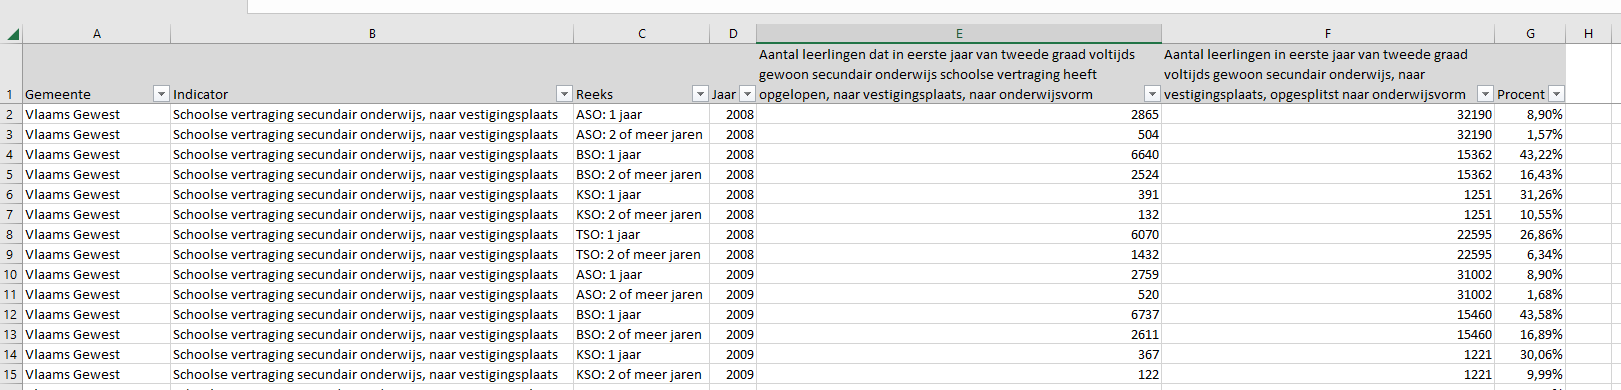

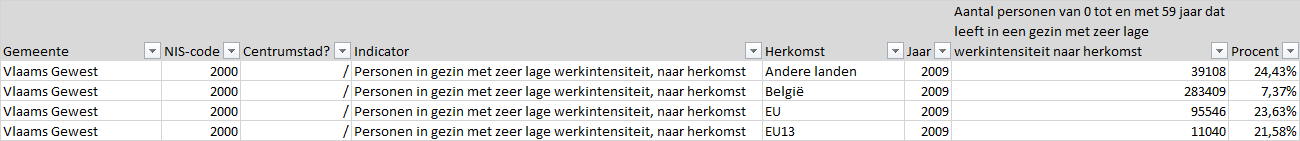

Heel moeilijk om hiermee om te gaan: Wat hou ik als eerste categorie? Vlaanderen precies meest geïnteresseerd in inwoners in de buurt van wijkgroen, enkel dat overgehouden (https://www.vlaanderen.be/statistiek-vlaanderen/milieu-en-natuur/nabijheid-van-groen)

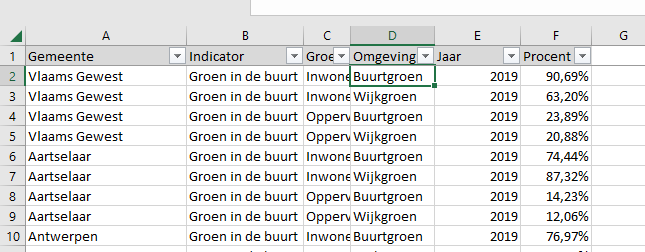 

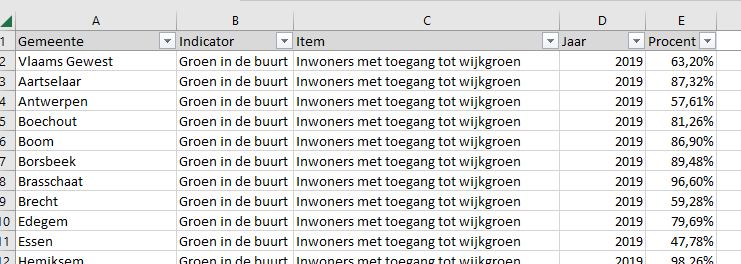

Te complex voor globale analyse

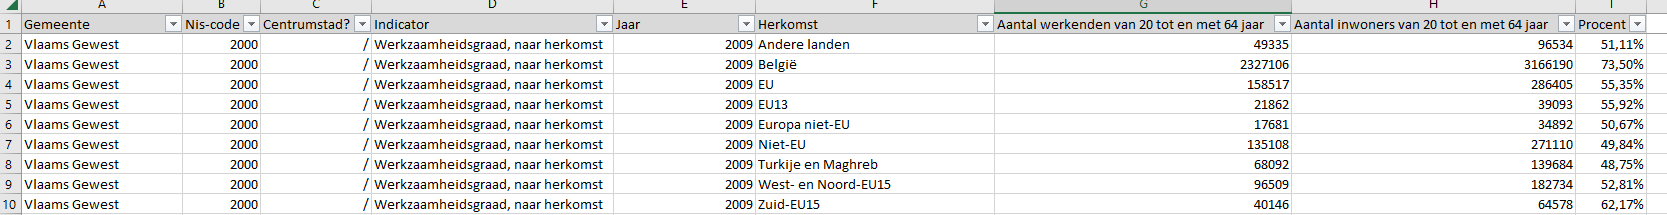

Vatten gelukkig zelf samen

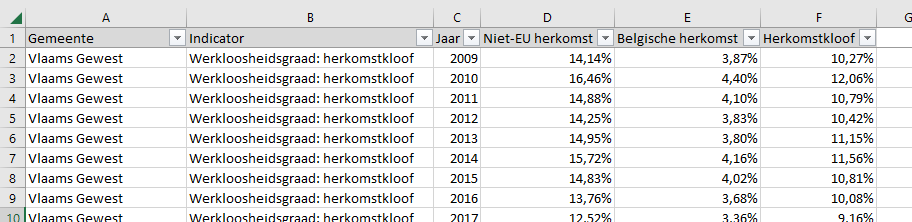

Spanningsration: interessante indicator, maar niet op lokaal niveau, mensen kijken verder dan eigen gemeente voor werk

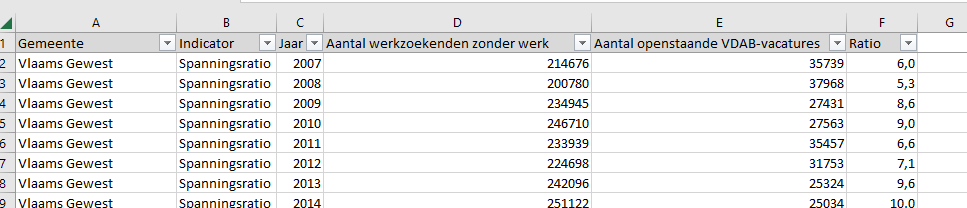

In [3]:
%%time
DTYPES = {'Jaar': 'int', 'Waarde': 'float', 'Eerste categorie': 'bool'}
#category dtype gaat verloren bij concat https://stackoverflow.com/questions/45639350/retaining-categorical-dtype-upon-dataframe-concatenation
CATEGORICALS = {'Indicator ID': 'category', 'Indicator': 'category', 'Gemeente': 'category', 'Item': 'category', 'Categorie': 'category'} 

for f in os.scandir("registerindicatoren_clean"):
    collation = []
    if not f.is_file():
        continue
    (filename, extension) = os.path.basename(f.path).split('.')
    with pd.ExcelFile(f.path) as xlsx:
        for sheet_name in xlsx.sheet_names[1:]: #skip first sheet (=overview)
            df_tmp = pd.read_excel(xlsx, sheet_name)
            #strip leading & trailing whitespace from column names
            df_tmp.columns = df_tmp.columns.str.strip()
            #Bij budgettaire indicatoren wordt er vaak kolom 'Boekjaar' gebruikt; uniformiseren naar 'Jaar'
            if 'Boekjaar' in df_tmp.columns:
                df_tmp = df_tmp.rename(columns={'Boekjaar':'Jaar'})
            #enkel waarden voor jaren vanaf 2017 overhouden
            df_tmp = df_tmp[df_tmp['Jaar'] >= 2017]
            #eventuele spaties in en rond gemeentenamen schrappen
            df_tmp['Gemeente'] = df_tmp['Gemeente'].str.strip()
            #Waarden voor verschillende besturen optellen (AGB, Gemeente, OCMW); is gelukkig altijd dezelfde waardenkolom [Totaal per inwoner]
            if 'Bestuur' in df_tmp.columns:
                df_tmp = df_tmp.groupby(['Gemeente', 'Indicator', 'Jaar'])['Totaal per inwoner'].sum().reset_index()
            #voorkeursmeetcategorie standaard vaststellen op !laatste! categorie
            first_category = df_tmp.columns[-1] #moet gebeuren vóór er kolommen worden toegevoegd
            #Indicator key toevoegen, underscore toevoegen die blijkbaar ontbreekt in sheetnames bij registerindicatoren
            df_tmp['Indicator ID'] = "{}_{}".format(sheet_name[:2], sheet_name[2:])
            #Voeg een lege Item-kolom toe als er nog geen bestaat, voor de uniformiteit
            if 'Item' not in df_tmp:
                df_tmp['Item'] = None
            #Percentages soms als <100 en soms als <1; uniformiseren naar < 1 
            if ('Procent' in df_tmp.columns) and (df_tmp['Procent'].quantile(0.98) > 1): #98ste quantiel iets robuuster naar fouten in de data, hoop ik; TE TESTEN!
                df_tmp['Procent'] = df_tmp['Procent'] / 100
                df_tmp['Procent'] = df_tmp['Procent'].round(2)
            #unpivot
            df_tmp = df_tmp.melt(id_vars=['Indicator ID', 'Indicator', 'Gemeente', 'Item', 'Jaar'], var_name="Categorie", value_name="Waarde")
            #string 'nvt' geeft problemen bij conversie kolom naar getal in Power BI:
            df_tmp = df_tmp[df_tmp['Waarde'] != 'nvt'] #filter out all rows with waarde = 'nvt'; alternatief: df_tmp['Waarde'] = df_tmp['Waarde'].replace('nvt',None)
            df_tmp['Eerste categorie'] = (df_tmp['Categorie'] == first_category)
            df_tmp = df_tmp.astype(DTYPES)
            collation.append(df_tmp)
    df_registerfacts = pd.concat(collation)
    df_registerfacts = df_registerfacts.astype(CATEGORICALS)
    print(df_registerfacts.shape)
    df_registerfacts.to_excel('output/{}_register_facts.xlsx'.format(filename), index=False)
    print('written to output/{}_register_facts.xlsx'.format(filename))

(41210, 8)
written to output/GSM_register_Armoede_register_facts.xlsx
(28680, 8)
written to output/GSM_register_Cultuur_en_vrije_tijd_register_facts.xlsx
(115584, 8)
written to output/GSM_register_Demografie_register_facts.xlsx
(47546, 8)
written to output/GSM_register_Economie_register_facts.xlsx
(11039, 8)
written to output/GSM_register_Klimaat_milieu_en_natuur_register_facts.xlsx
(42709, 8)
written to output/GSM_register_Lokaal_bestuur_register_facts.xlsx
(15598, 8)
written to output/GSM_register_Mobiliteit_register_facts.xlsx
(24036, 8)
written to output/GSM_register_Onderwijs_en_vorming_register_facts.xlsx
(4816, 8)
written to output/GSM_register_Ruimte_register_facts.xlsx
(3010, 8)
written to output/GSM_register_Samenleven_register_facts.xlsx
(2400, 8)
written to output/GSM_register_Vlaamse_Rand_register_facts.xlsx
(10571, 8)
written to output/GSM_register_Werk_register_facts.xlsx
(35638, 8)
written to output/GSM_register_Wonen_en_woonomgeving_register_facts.xlsx
(26701, 8)
writt

## correlaties in beeld brengen🧪
Verdient misschien nog verdere analyse met Exploratory Factor Analysis https://www.datacamp.com/tutorial/introduction-factor-analysis

### Test met enkel surveydata

In [2]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

In [3]:
%%time
DTYPES = {
    'Indicator ID': 'category', 
    'Indicator': 'category', 
    'Gemeente' : 'category', 
    'Item': 'category',
    'Jaar': 'int',
    'Categorie': 'category',
    'Waarde': 'float',
    'Eerste categorie': 'bool'
}

df = pd.read_excel("output/survey_facts.xlsx", 0, dtype=DTYPES) #zonder category dtypes kom je om >18 MB in het geheugen, mét op maar 7.7 MB
df = df[
    (df["Eerste categorie"]==True) & 
    (df["Jaar"].isin([2017, 2020])) &
    ~(df["Gemeente"].isin(AGGREGATIES))
]

def header(r):
    if pd.isna(r['Item']):
        s = "{}:{}>{}".format(r['Indicator ID'], r['Indicator'], r['Categorie'])
    else:
        s = "{}:{}>{}>{}".format(r['Indicator ID'], r['Indicator'], r['Item'], r['Categorie'])
    return s.replace(',', '-') #komma's uit toekomstige kolomkoppen schrappen om csv-problemen te vermijden
        
df['Header'] = df.apply(header, axis=1).astype('category')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109200 entries, 2 to 364334
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Indicator ID      109200 non-null  category
 1   Indicator         109200 non-null  category
 2   Gemeente          109200 non-null  category
 3   Item              70280 non-null   category
 4   Jaar              109200 non-null  int32   
 5   Categorie         109200 non-null  category
 6   Waarde            109200 non-null  float64 
 7   Eerste categorie  109200 non-null  bool    
 8   Header            109200 non-null  category
dtypes: bool(1), category(6), float64(1), int32(1)
memory usage: 3.4 MB
CPU times: total: 41.9 s
Wall time: 42.1 s


,Indicator ID,Indicator,Gemeente,Item,Jaar,Categorie,Waarde,Eerste categorie,Header
2,AR_S_01,Betalingsmoeilijkheden,Aalst,NaN,2017,Ja (%),0.14,True,AR_S_01:Betalingsmoeilijkheden>Ja (%)
3,AR_S_01,Betalingsmoeilijkheden,Aalst,NaN,2020,Ja (%),0.13,True,AR_S_01:Betalingsmoeilijkheden>Ja (%)
4,AR_S_01,Betalingsmoeilijkheden,Aalter,NaN,2017,Ja (%),0.07,True,AR_S_01:Betalingsmoeilijkheden>Ja (%)
5,AR_S_01,Betalingsmoeilijkheden,Aalter,NaN,2020,Ja (%),0.07,True,AR_S_01:Betalingsmoeilijkheden>Ja (%)
6,AR_S_01,Betalingsmoeilijkheden,Aarschot,NaN,2017,Ja (%),0.07,True,AR_S_01:Betalingsmoeilijkheden>Ja (%)


#### Matrix, correlatiematrix en geclusterde correlatiematrix van alle meetwaarden voor 2020 voor alle surveyindicatoren voor alle gemeenten
- opgelet, voor registerindicatoren is er niet altijd een waarde voor 2020, zou dan best de recentste nemen

In [4]:
%%time
df_jaarkolommen = pd.pivot_table(df, index=['Gemeente', 'Header'], columns=['Jaar'], values='Waarde').reset_index()
df_jaarkolommen.columns = df_jaarkolommen.columns.astype('string') #anders probs met 2017 en 2020 als integer kolomnamen
df_jaarkolommen.columns = df_jaarkolommen.columns.rename('Index')
df_jaarkolommen.dropna(subset='2020') #rijen zonder waarde voor 2020 laten vallen

df_2020 = pd.pivot_table(df_jaarkolommen, index=['Gemeente'], columns=['Header'], values='2020').reset_index()
df_2020 = df_2020.round(2)
df_2020.to_csv('output/matrix_2020_waarden.csv', index=False, float_format='%g') #https://stackoverflow.com/questions/12877189/float64-with-pandas-to-csv
df_2020_corr = df_2020.corr(numeric_only=True)
df_2020_corr.to_excel('output/matrix_2020_correlaties.xlsx', float_format='%.2f')

linkage_data = linkage(df_2020_corr.abs(), method='ward', metric='euclidean') #cluster by absolute correlation
ordered = leaves_list(linkage_data)
df_2020_corr.info()
df_2020_corr_hclust = df_2020_corr.iloc[:, ordered] #reorder columns, https://sparkbyexamples.com/pandas/pandas-set-order-of-columns-in-dataframe/
df_2020_corr_hclust = df_2020_corr_hclust.iloc[ordered] #reorder rows
df_2020_corr_hclust.to_excel('output/matrix_2020_correlaties_geclusterd.xlsx', float_format='%.2f')
#fig = plt.figure(figsize=(10,80))
#dendrogram(linkage_data, orientation='right') #, leaf_label_func=lambda x: df_2020_corr.columns[x])
#plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, AR_S_01:Betalingsmoeilijkheden>Ja (%) to ZO_S_10:Voldoende zorgvoorzieningen voor ouderen>NPS (%)
Columns: 233 entries, AR_S_01:Betalingsmoeilijkheden>Ja (%) to ZO_S_10:Voldoende zorgvoorzieningen voor ouderen>NPS (%)
dtypes: float64(233)
memory usage: 434.1+ KB
CPU times: total: 3.14 s
Wall time: 3.39 s


#### Matrix van de evolutie 2017-2020 voor alle surveyindicatoren voor alle gemeenten

In [173]:
#drop rijen zonder waarde voor 2017
df_delta = df_jaarkolommen.dropna(subset='2017')
df_delta['delta'] = df_delta['2020']-df_delta['2017']
df_delta = pd.pivot_table(df_delta, index=['Gemeente'], columns=['Header'], values='2020').reset_index()
#drop kolommen met lege waarden (sommige meetwaarden 2017 en dus delta's 2020-2017 alleen beschikbaar voor centrumsteden, sommige meetwaarden 2017 zijn alleen beschikbaar voor niet-centrumsteden) 
df_delta = df_delta.dropna(axis='columns') 
df_delta.to_csv('output/matrix_2020_2017_delta.csv', index=False, float_format='%g')

C:\Users\ward.kerckhof\AppData\Local\Temp\ipykernel_19900\2936228645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delta['delta'] = df_delta['2020']-df_delta['2017']


In [ ]:
%%time
DTYPES = {
    'Indicator ID': 'category', 
    'Indicator': 'category', 
    'Gemeente' : 'category', 
    'Item': 'category',
    'Jaar': 'int',
    'Categorie': 'category',
    'Waarde': 'float',
    'Eerste categorie': 'bool'
}
df = pd.DataFrame(columns="Indicator ID", "Indicator+Item+Categorie", "Jaar", "Waarde")

for f in os.scandir("output"):
    if not f.is_file():
        continue
    filename = os.path.basename(f.path)
    if filename.find("_facts") == -1: #geen fact table
        continue
    df = pd.read_excel("output/"+filename, 0, dtype=DTYPES, "Indicator ID", "Indicator", "Gemeente", "Item", "Jaar", "Categorie", "Waarde", "Eerste categorie")
    df = df[df["Eerste categorie"]==True & df["Jaar"].isin([2017, 2020]]

)

df_2020
df_delta


### Correlaties van surveydata 2020 en meest relevante registerdata
De registerdata dateren vaak van vroeger of soms van later dan 2020. 
Plan: 
- neem surveydata van 2020
- neem meest passende registerdata (2020 of laatst beschikbare jaar vóór 2020


In [5]:
%%time
DTYPES = {
    'Indicator ID': 'category', 
    'Indicator': 'category', 
    'Gemeente' : 'category', 
    'Item': 'category',
    'Jaar': 'int',
    'Categorie': 'category',
    'Waarde': 'float',
    'Eerste categorie': 'bool'
}

collation = []

df = pd.read_excel("output/survey_facts.xlsx", 0, dtype=DTYPES) #zonder category dtypes kom je om >18 MB in het geheugen, mét op maar 7.7 MB
df = df[
    (df["Eerste categorie"]==True) & 
    (df["Jaar"]==2020) &
    ~(df["Gemeente"].isin(AGGREGATIES))
]

collation.append(df)

for f in os.scandir("output"):
    if not f.is_file():
        continue
    filename = os.path.basename(f.path)
    if filename.find("register_facts") == -1: #geen register fact table
        continue
    df = pd.read_excel("output/"+filename, 0, dtype=DTYPES)
    meetjaren = df["Jaar"].unique()
    meetjaar = 2020
    while meetjaar not in meetjaren:
        meetjaar = meetjaar - 1
    df = df[
        (df["Eerste categorie"]==True) & 
        (df["Jaar"]==meetjaar) &
        ~(df["Gemeente"].isin(AGGREGATIES))
    ]
    collation.append(df)

df = pd.concat(collation)

def header(r):
    if pd.isna(r['Item']):
        s = "{}:{}>{}@{}".format(r['Indicator ID'], r['Indicator'], r['Categorie'], r['Jaar'])
    else:
        s = "{}:{}>{}>{}@{}".format(r['Indicator ID'], r['Indicator'], r['Item'], r['Categorie'], r['Jaar'])
    return s.replace(',', '-') #komma's uit toekomstige kolomkoppen schrappen om csv-problemen te vermijden
        
df['Header'] = df.apply(header, axis=1).astype('category')
df.info()

<timed exec>:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<timed exec>:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<timed exec>:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<timed exec>:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115057 entries, 3 to 24290
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Indicator ID      115057 non-null  object  
 1   Indicator         115057 non-null  object  
 2   Gemeente          115057 non-null  object  
 3   Item              63974 non-null   object  
 4   Jaar              115057 non-null  int32   
 5   Categorie         115057 non-null  object  
 6   Waarde            115023 non-null  float64 
 7   Eerste categorie  115057 non-null  bool    
 8   Header            115057 non-null  category
dtypes: bool(1), category(1), float64(1), int32(1), object(5)
memory usage: 6.9+ MB
CPU times: total: 1min 32s
Wall time: 1min 33s


In [1]:
n = "GSM_register_Cultuur_en_vrije_tijd_register_facts.xlsx"
print("{}test".format(15))
      


15test
